# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## <a id="0.0"></a> Содержание

* [1. Загрузка данных](#1.)
    * [1.1. Знакомство с данными, предобработка](#1.1.)
    * [1.2. Анализ данных](#1.2.)
* [2. Ответ на вопрос об умножении матриц](#2.)
* [3. Алгоритм преобразования](#3.)
* [4. Проверка алгоритма](#4.)
    * [4.1. Преобразование признаков](#4.1.)
    * [4.2. Обучение моделей, проверка качества](#4.2.)

## 1. Загрузка данных <a id="1."></a>
### 1.1. Знакомство с данными, предобработка <a id="1.1."></a>
[к содержанию](#0.0)

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [19]:
df = pd.read_csv('insurance.csv')

In [20]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [22]:
df.shape

(5000, 5)

In [23]:
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Заменим тип данных в поле с возрастом и зарплатой на целочисленный

In [24]:
df[['Возраст', 'Зарплата']] = df[['Возраст', 'Зарплата']].astype(int)

Проверим данные на полные дубликаты

In [25]:
print('Процент дубликатов: {:.2%}'.format(df.duplicated().sum() / df.shape[0]))

Процент дубликатов: 3.06%


В данном случае у клиентов нет уникальных id, остальные признаки могут просто совпадать у разных клиентов. Таким образом, нет однозначных оснований для их удаления.

### Вывод

Данные представляют собой информацию о клиента страховой компании, можно отметить следующее:
* датасет содержит 5000 строк и 5 столбцов;
* все поля количественные, 4 признака и 1 целевой признак - Страховые выплаты;
* пропущенные значения отсутствуют, аномально высокие или аномально низкие значения тоже.
* в данных присутствует 3.06% полных дубликатов, но так как у клиентов нет уникальных id, признаки просто могут совпадать у разных клиентов, они не были удалены.

### 1.2. Анализ данных <a id="1.2."></a>
[к содержанию](#0.0)

Посмотрим подробнее на данные

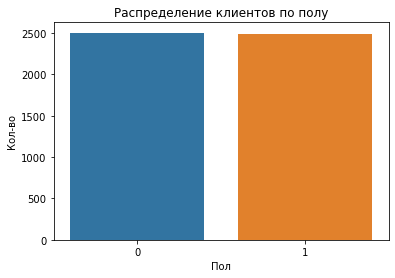

In [26]:
age_values = df['Пол'].value_counts().to_frame().reset_index().rename(columns={'index':'Пол',
                                                                'Пол':'Кол-во'})
sns.barplot(data = age_values, x='Пол', y='Кол-во') 
plt.title('Распределение клиентов по полу')
plt.show()

Видно, что мужчин и женщин в данных почти одинаковое к-во.

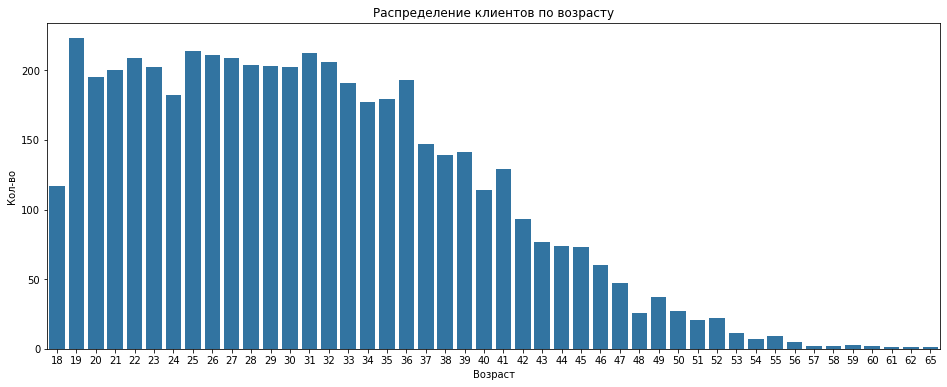

count    5000.000000
mean       30.952800
std         8.440807
min        18.000000
25%        24.000000
50%        30.000000
75%        37.000000
max        65.000000
Name: Возраст, dtype: float64

In [27]:
color=sns.color_palette("Paired")[1]
age_values = df['Возраст'].value_counts().to_frame().reset_index().rename(columns={'index':'Возраст',
                                                                                   'Возраст':'Кол-во'})
plt.figure(figsize=(16,6))
sns.barplot(data = age_values, x='Возраст', y='Кол-во', color=color)
plt.title('Распределение клиентов по возрасту')
plt.show()
df['Возраст'].describe()

Средний возраст клиентов 31 год, большая часть обратившихся в страховую - клиенты то 18 до 42 лет.

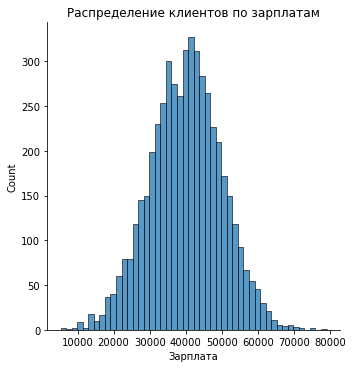

count     5000.000000
mean     39916.359400
std       9900.082063
min       5300.000000
25%      33300.000000
50%      40200.000000
75%      46600.000000
max      79000.000000
Name: Зарплата, dtype: float64

In [28]:
sns.displot(df['Зарплата'])
plt.title('Распределение клиентов по зарплатам')
plt.show()
df['Зарплата'].describe()

Средняя зарплата клиентов составляет 39916 рублей. Чаще всего клиенты зарабатывают от 33300 до 46600.

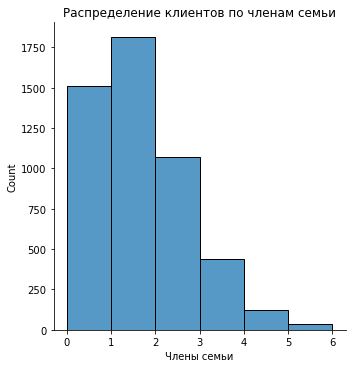

count    5000.000000
mean        1.194200
std         1.091387
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: Члены семьи, dtype: float64

In [29]:
sns.displot(df['Члены семьи'], bins=6)
plt.title('Распределение клиентов по членам семьи')
plt.show()
df['Члены семьи'].describe()

Чаще всего клиенты имеют одного родственника или не имеют совсем, реже 2 и более.

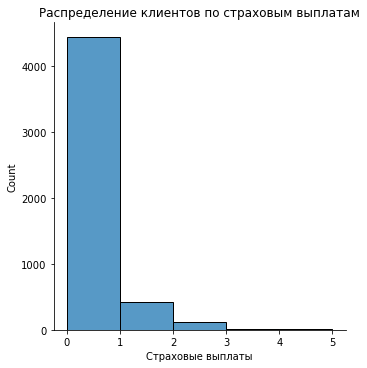

,К-во обращений,Процент клиентов
0,0,0.8872
1,1,0.0846
2,2,0.0230
3,3,0.0036
4,4,0.0014
5,5,0.0002


In [30]:
sns.displot(df['Страховые выплаты'], bins=5)
plt.title('Распределение клиентов по страховым выплатам')
plt.show()
df['Страховые выплаты'].value_counts(normalize=True).to_frame().\
    reset_index().rename(columns={'index':'К-во обращений','Страховые выплаты':'Процент клиентов'})

Большая часть клиентов не обращается за выплатами, всего 8.46% обращаются только 1 раз, еще 2.3% обращаются дважды

Посмотрим корреляцию признаков

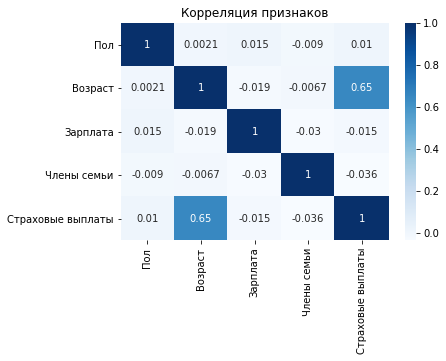

In [31]:
sns.heatmap(df.corr(), cmap='Blues', annot = True)
plt.title('Корреляция признаков')
plt.show()

Можно отметить прямую корреляцию 0.65 у возраста клиента и количества страховых выплат. 

### Вывод

Проанализировав данные можно отметить:
* мужчин и женин в данных почти одинаковое к-во;
* cредний возраст клиентов 31 год, большая часть обратившихся в страховую - клиенты то 18 до 42 лет;
* cредняя зарплата клиентов составляет 39916 рублей. Чаще всего клиенты зарабатывают от 33300 до 46600;
* чаще всего клиенты имеют одного родственника или не имеют совсем, реже 2 и более;
* большая часть клиентов не обращается за выплатами, всего 8.46% обращаются только 1 раз, еще 2.3% обращаются дважды;
* можно отметить прямую корреляцию 0.65 у возраста клиента и количества страховых выплат.

## 2. Ответ на вопрос об умножении матриц <a id="2."></a>
[к содержанию](#0.0)

***Ответим на вопрос и обоснуем решение.  
Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?***

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

- $Е$ — единичная матрица 

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** Не изменится

**Обоснование:** 

Новая матрица признаков:

$$X' = XP$$

Таким образом новый вектор весов $w'$ можем расчитать следующим образом:

$$
w' = ((XP)^{T} XP)^{-1} (XP)^{T} y = \\ 
     = (P^{T}X^{T} XP)^{-1}P^{T}X^{T}y  = \\ 
     = P^{-1} (X^{T} X)^{-1} (P^{T})^{-1} P^{T}X^{T}y = \\ 
     = P^{-1} w
$$ 
     
Так как внутри формулы можно выделить формулу расчета $w$, а

$$(P^{T})^{-1} P^{T} = Е = 1$$


Таким образом:

$$ a' = X'w' = XPP^{-1}w = XEw = Xw= a $$

Если любую матрицу Р умножить на единичную (или наоборот), получится эта же матрица Р. Таким образом, матрицы будут одинаковыми, а качество линейной регрессии не изменится.


### Вывод

При умножении признаков на обратимую матрицу качество линейной регрессии не изменится.

## 3. Алгоритм преобразования <a id="3."></a>
[к содержанию](#0.0)

Предложим алгоритм преобразования данных для решения задачи. Обоснуем, почему качество линейной регрессии не поменяется.

1) методом *make_spd_matrix* создаем случайную матрицу A

2) методом *np.linalg.inv()* проверяем матрицу А на обратимость и получаем $А^{-1}$. Если матрица А провалила тест на обратимость, создадим новую случайную матрицу. 

Поскольку нам надо закодировать данные клиентов, матрица А будет ключом кодирования. 

3) умножаем матрицу признаков X на полученную матрицу А и получаем матрицу B с закодированными данными о клиентах:

$$ B = X @ A $$

После этого можно переходить к обучению модели линейной регрессии. 


**Обоснование**

Такой алгоритм позволит защитить персональную информацию клиентов и при этом не должен повлиять на работу модели (ранее уже отмечалось, что качество модели не изменится, если матрицу признаков умножать на обратимую модель).

## 4. Проверка алгоритма <a id="4."></a>
## 4.1. Преобразование признаков <a id="4."></a>
[к содержанию](#0.0)

Созданим матрицу признаков.

In [32]:
# удалим значение целевого признака
features = df.drop(['Страховые выплаты'], axis=1)

# запишем матрицу в переменную, взяв значения датафрейма
features_matrix = features.values
features_matrix

array([[    1,    41, 49600,     1],
       [    0,    46, 38000,     1],
       [    0,    29, 21000,     0],
       ...,
       [    0,    20, 33900,     2],
       [    1,    22, 32700,     3],
       [    1,    28, 40600,     1]])

Создадим случайную матрицу и проверим её на обратимость.

In [33]:
# создадим матрицу
random_matrix = make_spd_matrix(n_dim=4, random_state=123)

# проверим на обратимость 
np.linalg.inv(random_matrix)

array([[ 2.97675307,  0.09601407, -0.43363796,  1.63149048],
       [ 0.09601407,  1.02415391, -1.2595126 ,  0.57122764],
       [-0.43363796, -1.2595126 ,  2.39108163, -0.46226306],
       [ 1.63149048,  0.57122764, -0.46226306,  4.18355526]])

Матрица обратима, умножим значения исходной матрицы на случайную матрицу.

In [34]:
new_matrix = features_matrix @ random_matrix

## 4.2. Обучение моделей, проверка качества <a id="4.2."></a>
[к содержанию](#0.0)

Проверим качество модели линейной регресси до умножения на случайную матрицу и после.
Для начала обучим модель на исходных данных.

In [35]:
# Запишем целевой признак в переменную
target = df['Страховые выплаты']

# Разделим данные на выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, 
    target, 
    train_size=0.75,
    test_size=0.25, 
    random_state=123
)

# обучим модель и применим метрику R2
model = LinearRegression()
model.fit(features_train, target_train)
prediction = model.predict(features_valid)
R2 = r2_score(target_valid, prediction)

Обучим модель, на признаках, умноженных на случайную матрицу

In [36]:
# Разделим данные на выборки
new_features_train, new_features_valid, new_target_train, new_target_valid = train_test_split(
    new_matrix, 
    target, 
    train_size=0.75,
    test_size=0.25, 
    random_state=123
)

# обучим модель и применим метрику R2
new_model = LinearRegression()
new_model.fit(new_features_train, new_target_train)
new_prediction = new_model.predict(new_features_valid)
new_R2 = r2_score(new_target_valid, new_prediction)

In [37]:
print('R2 модели до преобразования признаков:', R2)
print('R2 модели после преобразования признаков:', new_R2)

R2 модели до преобразования признаков: 0.43018469886063604
R2 модели после преобразования признаков: 0.4301846988612972


### Вывод

Как можно увидить, после преобразования качество линейной регрессии практически не поменялось. Таким образом, данный алгоритм можно использовать для кодирования данных клиентов.